In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="5">     <b>I. Classification</b>

<font size="4">    <b>Loading the data</b>

<font size="3" color='blue'>    <b>Offset correction for EMG -> +0.28 on Biceps</b>

In [2]:
pID = '7'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 1s
data_eeg_name_1 = '\data_s7_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name_1 = '\data_s7_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name_1 = '\data_s7_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg_1 = pd.read_csv(path+pID+data_eeg_name_1)

#Choose the data set to use, classifier EEG-EMG will only work if both modalities are on the safe timeframe
data_eeg = data_eeg_1

# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg))//win_eeg

In [3]:
data_eeg

,sample,epoch_ix,rp_class,FCz,Fz,FC3,C1,FC1,F1,F2,...,F4,C2,F6,CP2,CP1,FC4,FT7,CPz,CP6,C3
0,-0.996,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.992,1,1,-3.759857,-0.959855,1.640146,0.540144,0.340145,-1.159856,0.340141,...,0.240147,-2.959854,1.840149,-1.859856,-0.759855,-0.759855,3.363878,-1.559856,-2.566266,2.040146
2,-0.988,1,1,-5.860331,-0.760329,4.439669,1.139669,1.039669,-0.360330,3.039669,...,5.439671,-2.960329,4.439667,-3.560326,-0.860331,1.939671,8.578562,-2.060329,-0.881276,5.239672
3,-0.984,1,1,-6.098312,-1.398313,4.901688,0.901688,1.301685,-0.398311,2.301685,...,5.201691,-1.298311,6.501686,-1.698311,-0.398314,3.501688,8.599808,-0.998314,0.927430,3.701691
4,-0.980,1,1,-3.892704,-1.992704,-0.692703,1.507296,0.707294,-0.692702,3.507294,...,6.407299,1.107296,10.007294,0.907299,-0.192705,4.407295,3.679844,0.707294,0.321279,-0.392704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86995,-0.016,348,2,-49.296801,-58.096801,-29.896801,-32.096802,-39.296801,-52.096801,-45.496803,...,-38.196800,-41.096800,7.203197,-20.396801,-30.596802,-28.496799,-7.332270,-33.396800,90.369604,-34.696802
86996,-0.012,348,2,-47.467827,-56.267825,-28.167827,-27.567828,-36.367826,-52.667827,-49.567825,...,-44.267825,-37.267824,-6.967827,-15.667824,-25.367827,-32.467826,-5.322636,-29.867826,112.176903,-28.667826
86997,-0.008,348,2,-38.845121,-49.645122,-17.045122,-14.445124,-26.245121,-44.645122,-43.745121,...,-39.745121,-24.445122,-4.245117,-2.345119,-11.545122,-22.145120,3.913845,-17.345121,90.574152,-13.545122
86998,-0.004,348,2,-32.740486,-46.340487,-9.540486,-6.540489,-20.140486,-40.240487,-38.240486,...,-34.140486,-14.040487,11.059517,6.159515,-2.140487,-11.940485,6.517384,-7.840486,69.253353,-3.540486


In [4]:
#EEG 1st DataFrame
win_eeg_mean = data_eeg.groupby(win_eeg_scaled).mean() 

<font size="4">    <b>Data frames</b>
    
From the imported data structure to the final structure adapted for the following classification.

In [5]:
#EEG
df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)


<font size="4">    <b>Linear Discriminent Analysis</b>

<font size="3">    <b>EEG</b>

In [6]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.772436974789916
0.07535318061612847


<font size="3">    <b>Classification metrics - EMG</b>

<font size="5">     <b>II. Time serie representation (only done for EEG yet)</b>

Test the previously trained classifier on sliding windows over time.
Rather than testing the classifier on the whole stream of data, I will test it only on the interval [-2, 1] which should be enough, it would then speed up the processing delay.

This includes the following steps: Time interest definition - Baseline correction - Features extraction - Probability calculation - DataFrame and plot

<font size="3" color='red'>    <b>Load the data and keep 20 best EEG</b>

In [7]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\chans_rp-win_-1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None) # , dtype='float16'
velocity = pd.read_csv(pathm, header=None) # , dtype='float16'

# Select the best chans from the csv file to filter the eeg data
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg.iloc[i,:])
eeg_b = pd.DataFrame(eeg_b)

<font size="3" color='red'>    <b>Extract the time frame of interest around the movement onset</b>

In [8]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
epoch = np.zeros((len(onset), (b_onset + a_onset), eeg_b.shape[0]))

for k in range(len(onset)):
   
    for j in range(eeg_b.shape[0]):
    
        epoch[k, 0:(b_onset + a_onset), j] = eeg_b.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
       
        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='red'>    <b>Baseline correction: I think this messes up the final result</b>

In [9]:
#Try base line correction at the beginning of the epoch only, and each 250 trial as well
epoch_cor = np.zeros((epoch.shape))

for k in range(len(onset)):
    
    for j in range(eeg_b.shape[0]):
        
        for i in range((b_onset+a_onset)//250):
            
            epoch_cor[k, (250*i):250+(250*i), j] = epoch[k, (250*i):250+(250*i), j] - epoch[k, 250*i, j]

<font size="3" color='red'>    <b>EEG Feature extraction</b>

In [10]:
# (i and j) Extract the feature of size win_eeg 10 times per window on each channel. Each window is 250 samples.
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

fs = 250
nb_feat = fs//win_eeg
sld_size = 1

feat = np.zeros((len(epoch_cor), nb_feat*epoch_cor.shape[2], (epoch_cor.shape[1]//sld_size) - fs + sld_size))

for k in range(len(epoch_cor)):             # Onset index
    for l in range(feat.shape[2]):          # Window index
        for j in range(epoch_cor.shape[2]): # Channel index
            for i in range(nb_feat):        # Feature index
                feat[k, i+10*j, l] = np.mean(epoch_cor[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

In [11]:
feat.shape

(179, 200, 2751)

<font size="3" color='red'>    <b>Probability extraction</b>

In [12]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

proba = np.zeros((feat.shape[0], feat.shape[2]))

for k in range(len(epoch_cor)):
    
    for l in range(feat.shape[2]):
        
        proba[k, l] = clf_eeg.predict_proba(feat[k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>Final DataFrame and representation</b>

In [13]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba = np.reshape(proba, len(f_time))

m_velocity = actual_velocity[:, :proba.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data = np.zeros((len(f_time), 3))
f_data[:,0] = f_time
f_data[:,1] = f_velocity * 1000
f_data[:,2] = f_proba
final = pd.DataFrame(f_data, columns=['Time', 'Velocity', 'Probability'])
final

,Time,Velocity,Probability
0,-2.000,0.015379,0.850941
1,-1.999,0.016124,0.867542
2,-1.998,0.016677,0.874601
3,-1.997,0.017147,0.872739
4,-1.996,0.017212,0.871959
...,...,...,...
492424,0.746,0.490634,0.251213
492425,0.747,0.493741,0.227639
492426,0.748,0.495970,0.209255
492427,0.749,0.497510,0.190393


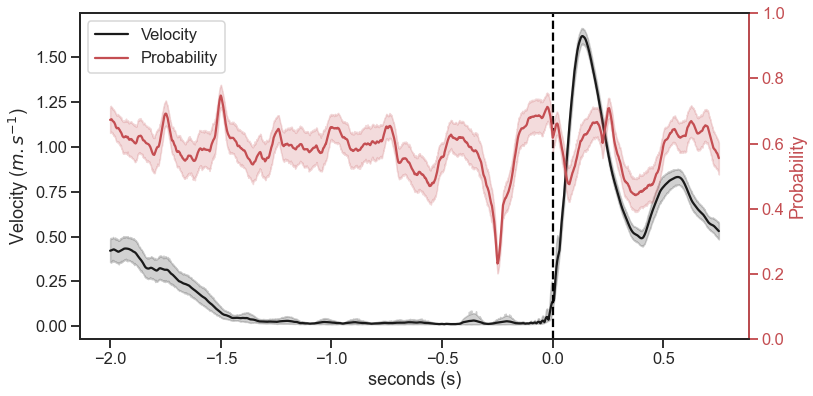

In [15]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
#plt.axvline(final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())],
#            color='green', label = 'onset')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))
# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

In [15]:
final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())]

-0.25